### Libraries

In [22]:
import re
import os
import nltk
import numpy as np
import pandas as pd
import networkx as nx
from PIL import Image
from pathlib import Path
from nltk import FreqDist
from fa2 import ForceAtlas2
from string import punctuation
from nltk import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import community as community_louvain
from nltk.tokenize import WordPunctTokenizer

#### Import scripts

In [23]:
from Scripts.frequent import frequent
from Scripts.sentiment import sentiment_function
from Scripts.community_name import community_name
from Scripts.sentiment_VADER import compute_sentiment_VADER

#### Create the directories

In [24]:
Path("Images").mkdir(parents=True, exist_ok=True)
Path("Token_Char").mkdir(parents=True, exist_ok=True)
Path("Images/Plots").mkdir(parents=True, exist_ok=True)
Path("Images/Networks").mkdir(parents=True, exist_ok=True)
Path("Images/Wordclouds").mkdir(parents=True, exist_ok=True)
Path("Token_Char/Episode_IV").mkdir(parents=True, exist_ok=True)
Path("Images/Wordclouds/Episode_IV").mkdir(parents=True, exist_ok=True)

#### Load data

In [25]:
data_scenes = pd.read_pickle('Data/Movies.pkl')
data_lines = pd.read_pickle('Data/Dialogues.pkl')

#### Count dialogues between characters

In [26]:
temp_data = data_scenes[data_scenes['Movie']=='Episode IV'].reset_index(drop=True)
char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()

char_data = pd.DataFrame(columns=list(char_dial[0].unique()))
for char in list(char_dial[0].unique()):
    temp_char_dial = []
    for c_dial in list(char_dial[0].unique()):
        counter = 0
        for scene in range(len(temp_data)):
            if temp_data['Scene_Characters'][scene]!=None:
                if (c_dial in temp_data['Scene_Characters'][scene]) and (char in temp_data['Scene_Characters'][scene]):
                    counter += 1
        temp_char_dial.append(counter)
    char_data.loc[len(char_data)] = temp_char_dial    
char_data.index = list(char_dial[0].unique())

<ipython-input-26-ed89f51252f9>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()


#### Create the network

In [27]:
G = nx.DiGraph()
for temp_char in list(char_dial[0].unique()):
    # Add nodes
    G.add_node(temp_char)
    
    # Add edges
    for char_edge in list(char_dial[0].unique()):
        if (temp_char != char_edge) and (char_data.loc[temp_char, char_edge] != 0):
            G.add_edge(temp_char, char_edge, weight=char_data.loc[temp_char, char_edge]) 

#### Number of nodes

In [28]:
print("Number of nodes in the network:", G.number_of_nodes())

Number of nodes in the network: 61


#### Number of edges

In [29]:
print("Number of links in the network:", G.number_of_edges())

Number of links in the network: 284


#### Degree network

In [30]:
connections_in = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)
print('In Degree Connections:')
for character, in_degree in connections_in[:10]:
    node = G.nodes[character]
    print(character.ljust(30), in_degree)

In Degree Connections:
LUKE                           31
THREEPIO                       20
LEIA                           16
VADER                          15
HAN                            13
BIGGS                          12
BEN                            11
TARKIN                         10
TROOPER                        9
FIRST TROOPER                  8


#### Visualize the network

100%|██████████| 1000/1000 [00:00<00:00, 3043.53it/s]


BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.17  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


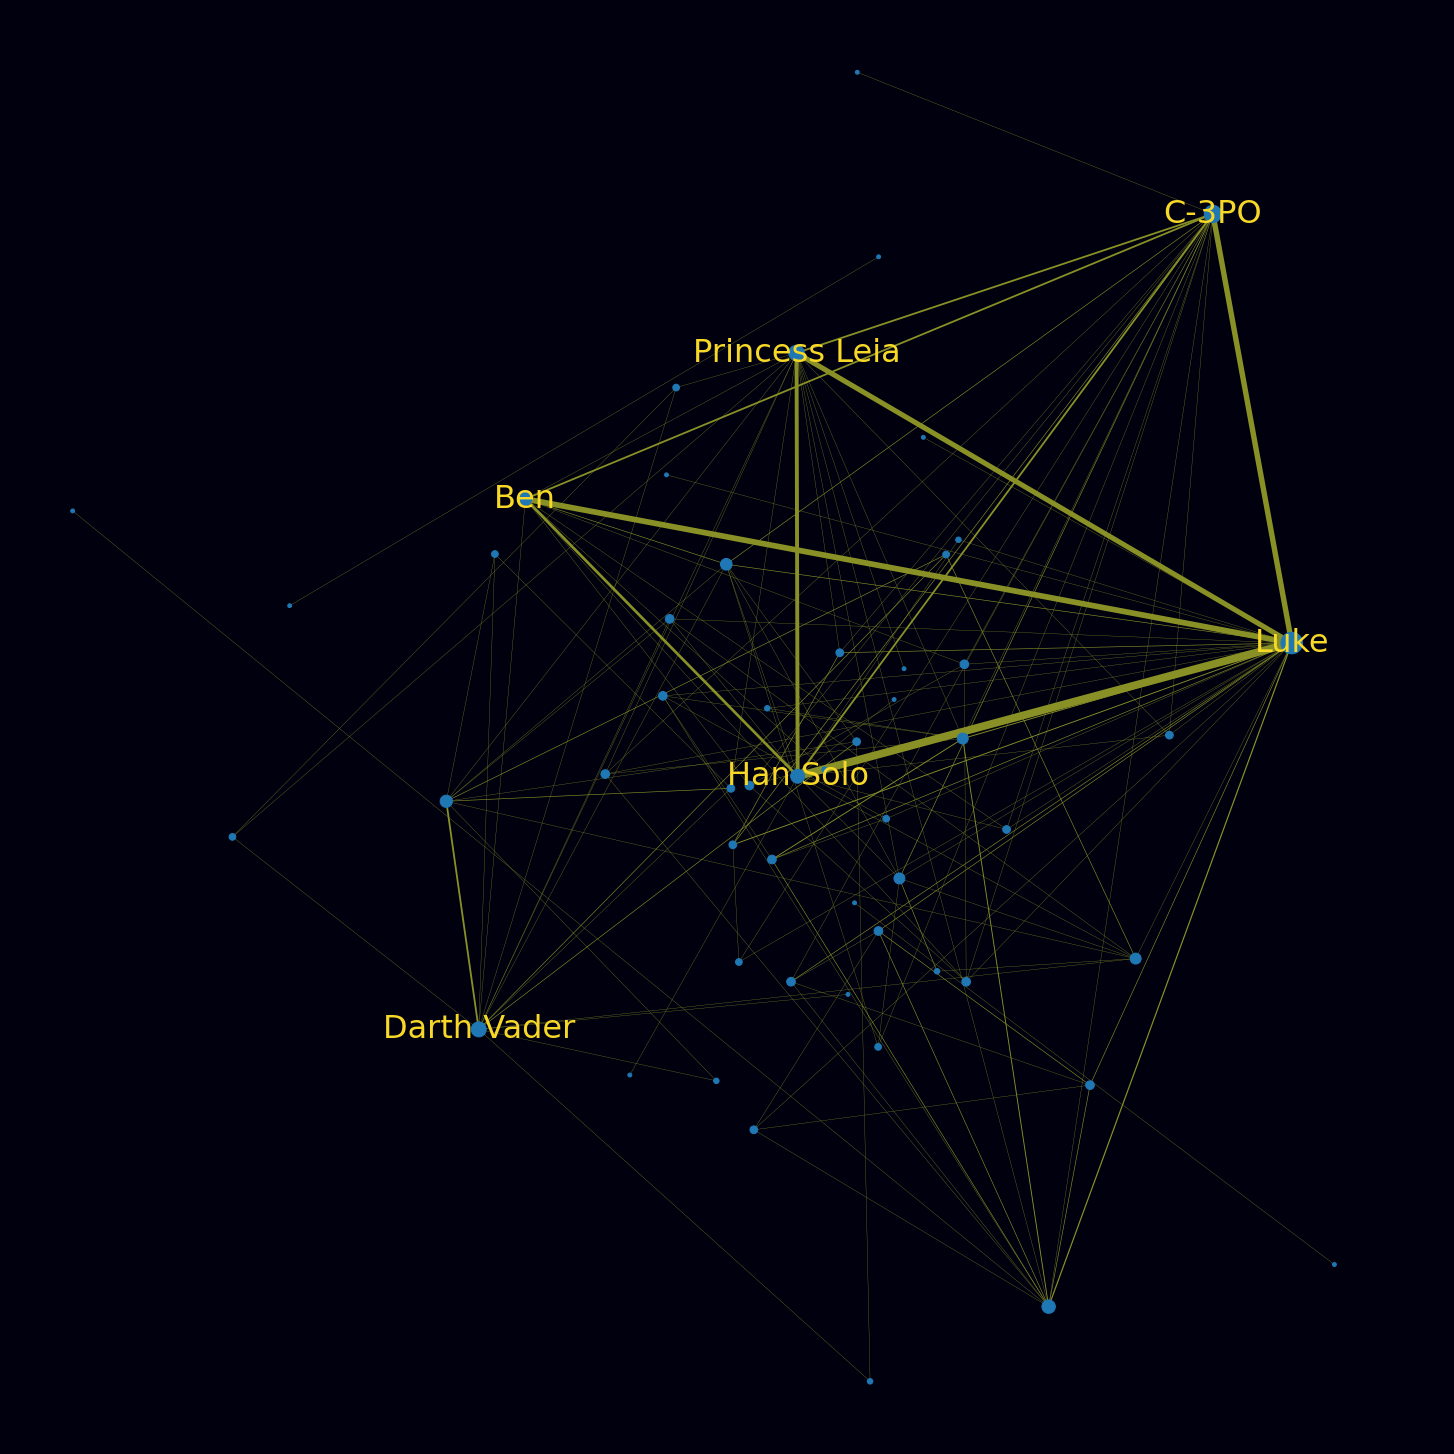

In [31]:
G = G.to_undirected()

forceatlas2 = ForceAtlas2(scalingRatio = 100, gravity = 1000)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = [degree*15 for degree in dict(G.degree()).values()]
edge_sizes = [G[u][v]['weight']*0.3 for u,v in G.edges()]

# Plotting
fig = plt.figure(figsize = (20, 20))
nx.draw(G, pos=positions, node_size=node_sizes, edge_color='#899126', width = edge_sizes)
nx.draw_networkx_labels(G, positions, {'LUKE':'Luke', 'THREEPIO':'C-3PO', 'LEIA':'Princess Leia',
                                       'VADER':'Darth Vader', 'HAN':'Han Solo', 'BEN': 'Ben'}, 
                        font_size=32, font_color='#F8D827')

fig.set_facecolor("#00000F")
plt.savefig("Images/Networks/Episode_IV.png", format="PNG")
plt.show()

#### Characters timeline

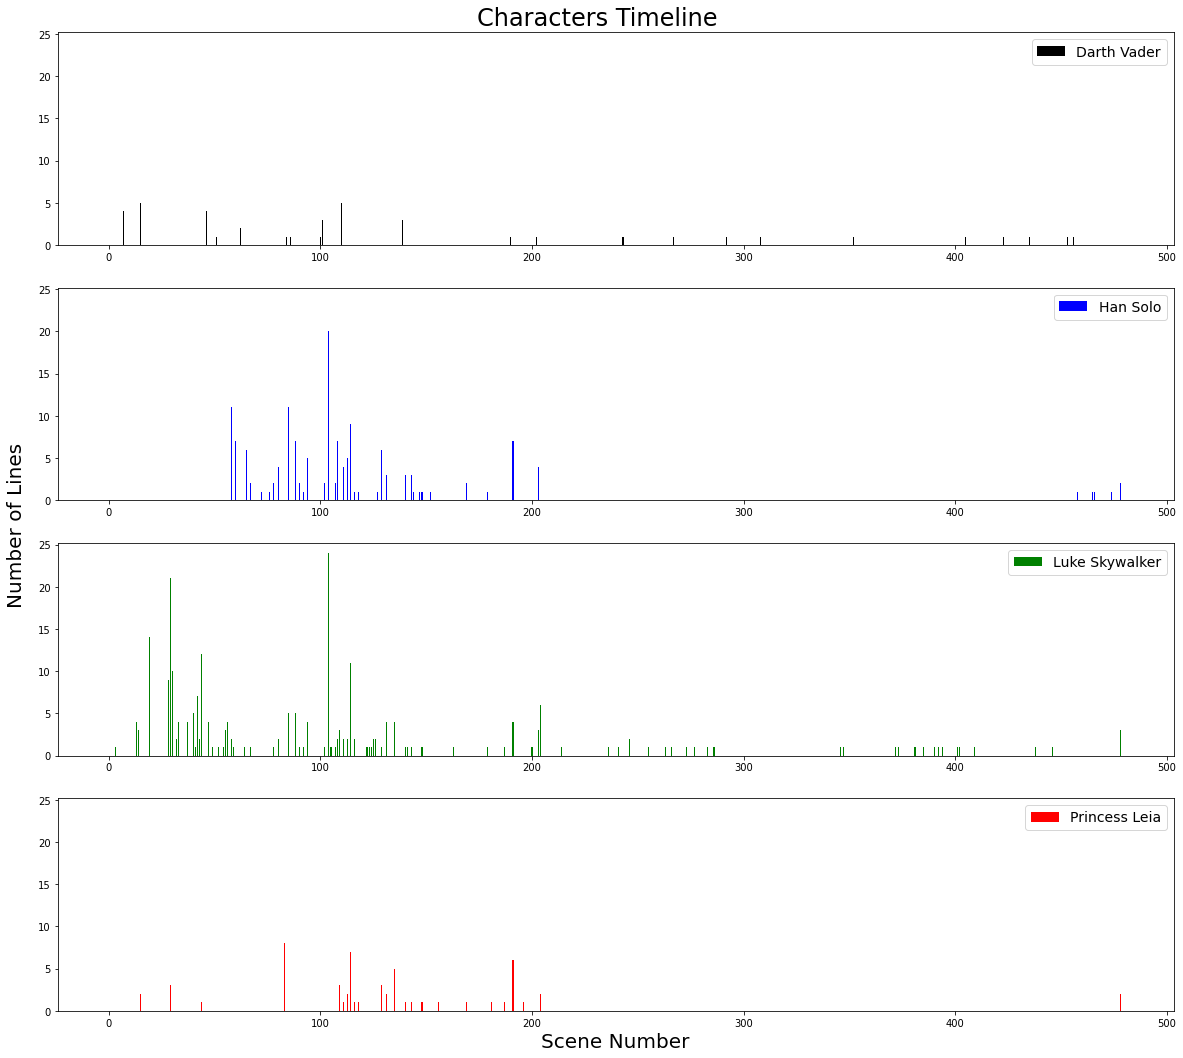

In [32]:
Darth_Vader, Han_Solo, Leia, Luke = [], [], [], []

for scene in range(len(temp_data['Scene_Characters'])):
    if temp_data['Scene_Characters'][scene] != None:
        Darth_Vader.append(temp_data['Scene_Characters'][scene].count('VADER'))
        Han_Solo.append(temp_data['Scene_Characters'][scene].count('HAN'))
        Leia.append(temp_data['Scene_Characters'][scene].count('LEIA'))
        Luke.append(temp_data['Scene_Characters'][scene].count('LUKE'))
    else:
        Darth_Vader.append(0)
        Han_Solo.append(0)
        Leia.append(0)
        Luke.append(0)
        
temp_characters = [Darth_Vader, Han_Solo, Luke, Leia]
labels = ['Darth Vader', 'Han Solo', 'Luke Skywalker', 'Princess Leia']
colors = ['Black', 'Blue', 'Green', 'Red']

fig = plt.figure(figsize=(20, 18))
X_axis = np.arange(len(temp_data))
for i, temp_char in enumerate(temp_characters):
    if i != 0:
        ax = fig.add_subplot(len(temp_characters), 1, i+1, sharex=temp_ax, sharey=temp_ax)
    else:
        ax = fig.add_subplot(len(temp_characters), 1, i+1)
    temp_ax = ax
    ax.bar(X_axis, temp_char, 0.5, label=labels[i], color=colors[i])
    ax.legend(loc='upper right', fontsize=14)

fig.suptitle("Characters Timeline", fontsize=24, y=0.9)    
plt.xlabel("Scene Number", fontsize=20)
fig.text(0.09, 0.5, 'Number of Lines', va='center', rotation='vertical', fontsize=20)
plt.savefig("Images/Plots/Char_Timeline_Ep_IV.png", format="PNG")
plt.show()

#### Count how many times specific characters are mentioned

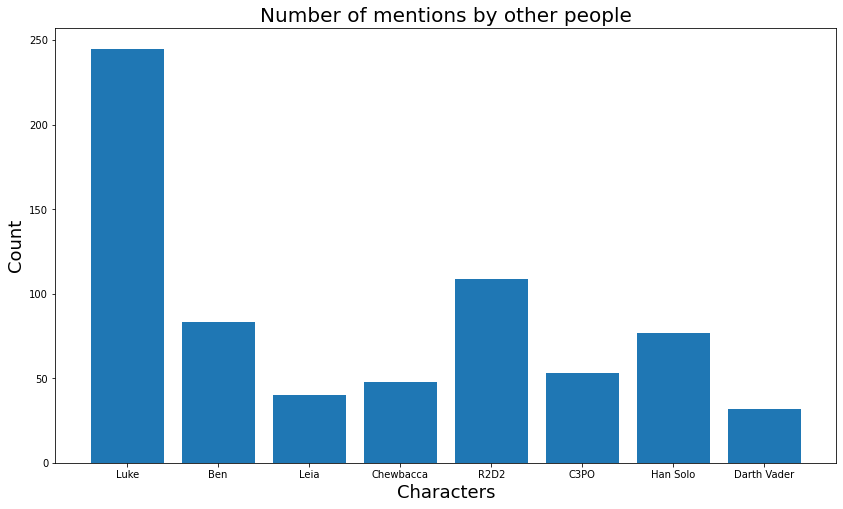

In [33]:
characters = ['Luke', 'Artoo', 'Han', 'Threepio', 'Ben', 'Vader', 'Chewbacca', 'Chewie', 'Obiwan', 'R2', 'Leia']

# Creating a list with every scene line
all_words = []
for scene in temp_data['Scene_Dialogue']:
    if scene != None:
        for phrase in scene:
            all_words.append(phrase)

# Creating one big string
string = ''.join(all_words)            

# Split string by every word
splitted_string = re.split(r"[\b\W\b]+", string)
splitted_string.remove('')

# Keep the words that start with a capital letter
names = []
for w in splitted_string:
    if w != '':
        if w[0].isupper():
            w = w.title()
            names.append(w)

# Count the occurencies
names = frequent(names)

# Keep specific characters
char_dict = {}
for i in range(len(names)):
    if names[i][0] in characters:
        if names[i][0] == 'Jar':
            char_dict[names[i][0]] = names[i][1]/2
        else:
            char_dict[names[i][0]] = names[i][1]

# Configurations
char_dict['Artoo'] += char_dict['R2']
char_dict.pop('R2', None)
char_dict['R2D2'] = char_dict.pop('Artoo')
char_dict['C3PO'] = char_dict.pop('Threepio')    
char_dict['Han Solo'] = char_dict.pop('Han')
char_dict['Darth Vader'] = char_dict.pop('Vader')
char_dict['Chewbacca'] += char_dict['Chewie']
char_dict.pop('Chewie', None)
char_dict['Ben'] += char_dict['Obiwan']
char_dict.pop('Obiwan', None)

# Plotting
plt.figure(figsize=(14,8))
plt.bar(*zip(*char_dict.items()))
plt.title('Number of mentions by other people', fontsize=20)
plt.xlabel('Characters', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.savefig("Images/Plots/Mentions_Ep_IV.png", format="PNG")
plt.show()

#### Calculate the nodes with the highest degree centrality

In [34]:
d_centrality = sorted(nx.degree_centrality(G).items(), 
                      key=lambda t: t[1], 
                      reverse=True)

for i in d_centrality[:10]:
    print(i)

('LUKE', 0.5166666666666666)
('THREEPIO', 0.3333333333333333)
('LEIA', 0.26666666666666666)
('VADER', 0.25)
('HAN', 0.21666666666666667)
('BIGGS', 0.2)
('BEN', 0.18333333333333332)
('TARKIN', 0.16666666666666666)
('TROOPER', 0.15)
('FIRST TROOPER', 0.13333333333333333)


#### Calculate number of communities and the value of modularity

In [35]:
partition = community_louvain.best_partition(G)
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]
modularity_louvain = nx.algorithms.community.modularity(G,communities_louvain)

print(f'Number of Communities: {len(set(partition.values()))}')
print(f'Value of Modularity: {modularity_louvain}')

Number of Communities: 13
Value of Modularity: 0.3417241379310345


#### Distribution of communities

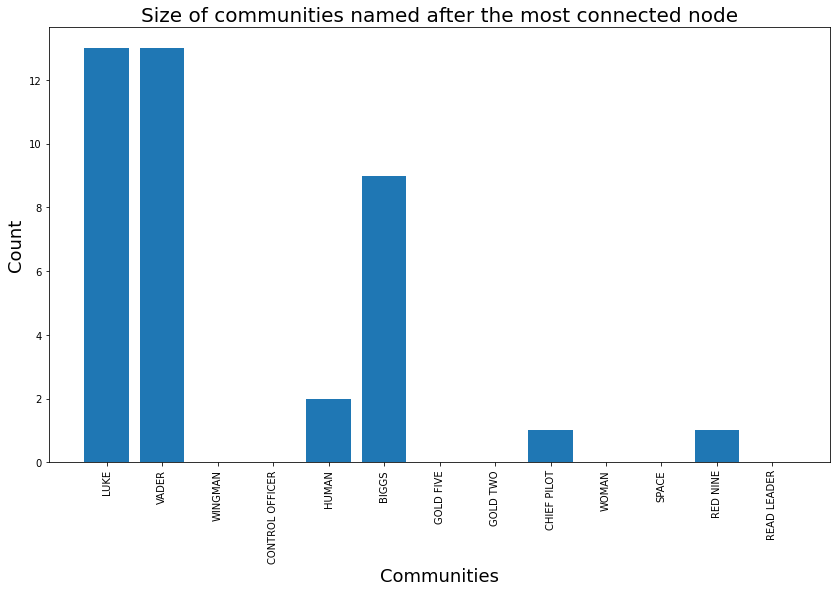

In [36]:
node_to_partition_id = community_louvain.best_partition(G)
partition_id_to_name = {partition_id: community_name(G, node_to_partition_id, partition_id) 
                        for partition_id in set(node_to_partition_id.values())}

community_size = {}
for key in partition_id_to_name.keys():
    community_size[partition_id_to_name[key][0][0]] = partition_id_to_name[key][0][1]
    
plt.figure(figsize=(14,8))
plt.bar(*zip(*community_size.items()))
plt.title('Size of communities named after the most connected node', fontsize=20)
plt.xlabel('Communities', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=90)
plt.savefig("Images/Plots/Dist_Community_Ep_IV.png", format="PNG")
plt.show()

#### Read the sentiment of words

In [37]:
LabMT = pd.read_csv('./Files/Data_Set_S1.txt', sep="\t", skiprows = 2)
LabMT_dict = pd.Series(LabMT.happiness_average.values,index=LabMT.word.values).to_dict()

#### Create a list of all the word per scene

In [38]:
words_scene = []
for i, temp_scene in enumerate(temp_data['Scene_Dialogue']):
    string = ''
    if temp_scene != None:
        #temp_scene = temp_scene.reset_index(drop=True)
        for temp_temp_scene in temp_scene:
            if temp_temp_scene != None:
                string += ''.join([elem for elem in temp_temp_scene])
        words_scene.append(string)
    else:
        words_scene.append(temp_data['Scene_Description'][i][0])

#### Calculate the sentiment per scene

In [39]:
corpus = {}
tokens = {}
for scene_number, scene in enumerate(words_scene):
    corpus[scene_number] = scene
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])

#### Visualize sentiment per scene (LabMT)

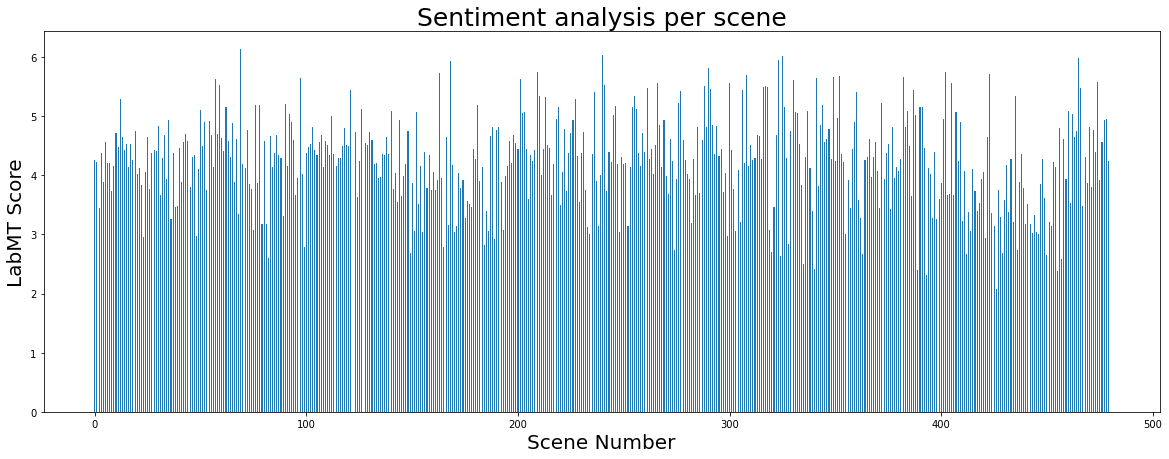

In [40]:
plt.figure(figsize=(20, 7))
plt.bar(X_axis, list(sentiment_dict_LabMT.values()), 0.5)
plt.title('Sentiment analysis per scene', fontsize=25)
plt.xlabel("Scene Number", fontsize=20)
plt.ylabel("LabMT Score", fontsize=20)
plt.savefig("Images/Plots/SA_per_Scene_Ep_IV_LabMT.png", format="PNG")
plt.show()

#### Visualize sentiment per scene (VADER)

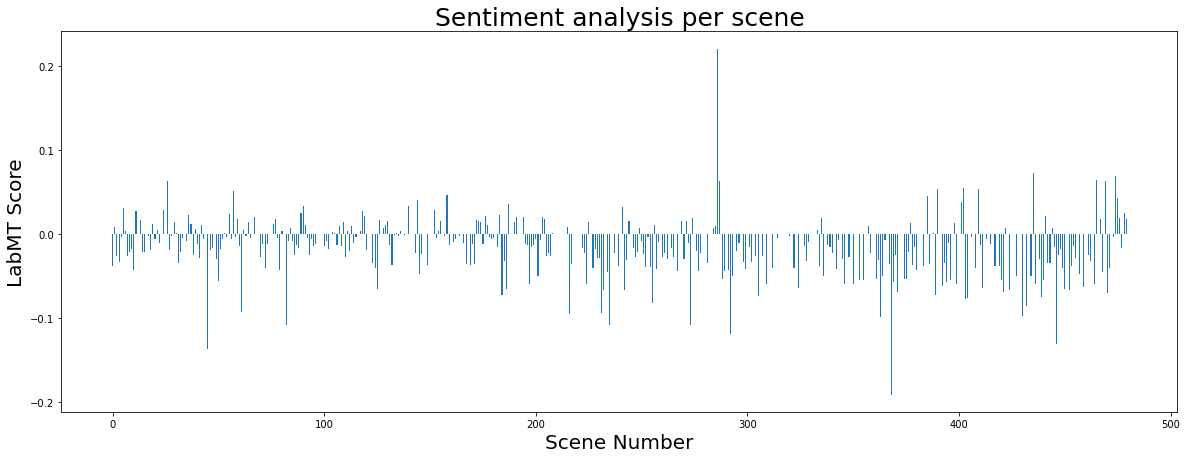

In [41]:
plt.figure(figsize=(20, 7))
plt.bar(X_axis, list(sentiment_dict_VADER.values()), 0.5)
plt.title('Sentiment analysis per scene', fontsize=25)
plt.xlabel("Scene Number", fontsize=20)
plt.ylabel("LabMT Score", fontsize=20)
plt.savefig("Images/Plots/SA_per_Scene_Ep_IV_VADER.png", format="PNG")
plt.show()

#### Calculate the sentiment up until the scene

In [42]:
corpus = {}
tokens = {}
for scene_number, scene in enumerate(words_scene):
    if scene_number == 0:
        corpus[scene_number] = scene 
    else:
        corpus[scene_number] = corpus[scene_number-1] + scene 
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])

#### Visualize sentiment per scene (LabMT)

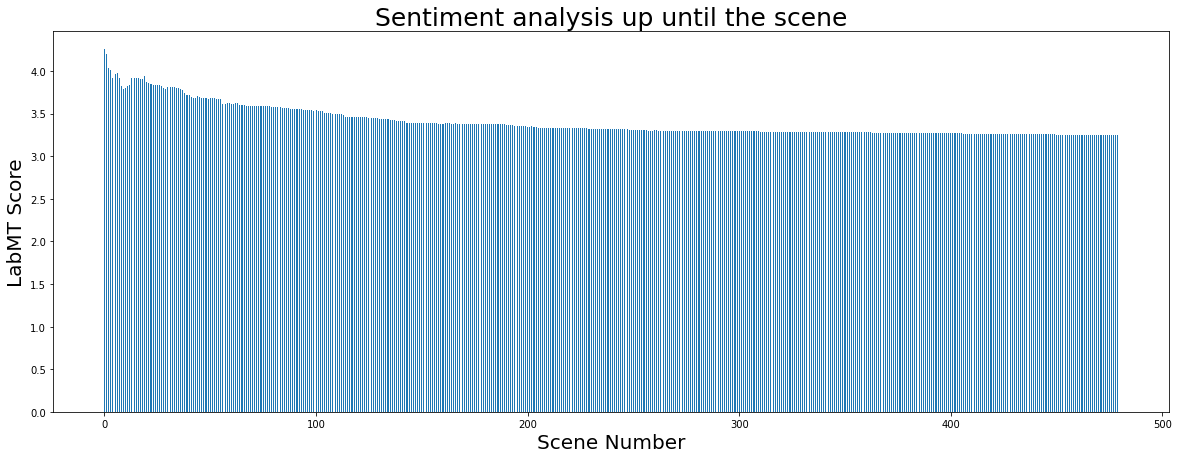

In [43]:
plt.figure(figsize=(20, 7))
plt.bar(X_axis, list(sentiment_dict_LabMT.values()), 0.5)
plt.title('Sentiment analysis up until the scene', fontsize=25)
plt.xlabel("Scene Number", fontsize=20)
plt.ylabel("LabMT Score", fontsize=20)
plt.savefig("Images/Plots/SA_until_Scene_Ep_IV_LabMT.png", format="PNG")
plt.show()

#### Visualize sentiment per scene (VADER)

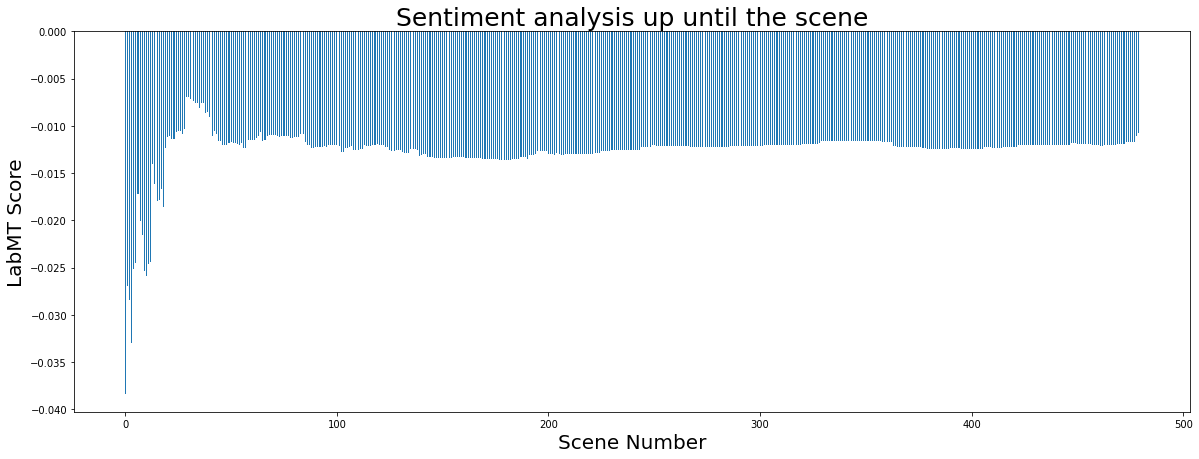

In [44]:
plt.figure(figsize=(20, 7))
plt.bar(X_axis, list(sentiment_dict_VADER.values()), 0.5)
plt.title('Sentiment analysis up until the scene', fontsize=25)
plt.xlabel("Scene Number", fontsize=20)
plt.ylabel("LabMT Score", fontsize=20)
plt.savefig("Images/Plots/SA_until_Scene_Ep_IV_VADER.png", format="PNG")
plt.show()

#### Sentiment score of the whole movie

In [45]:
print('LabMT Sentiment Score for the Movie: {:.5f}'.format(sentiment_dict_LabMT[len(sentiment_dict_LabMT)-1]))
print('VADER Sentiment Score for the Movie: {:.5f}'.format(sentiment_dict_VADER[len(sentiment_dict_VADER)-1]))

LabMT Sentiment Score for the Movie: 3.25061
VADER Sentiment Score for the Movie: -0.01076


#### Create a list of all the words per character

In [46]:
temp_lines = data_lines[data_lines['Movie']=='Episode IV']
words_char = {}

for temp_char in temp_lines['Character'].unique():
    temp_data = temp_lines[temp_lines['Character']==temp_char].reset_index(drop=True)
    string = ''
    for line in temp_data['Line']:
        string += line
    words_char[temp_char] = string

#### Calculate the sentiment for every character

In [47]:
corpus = words_char
tokens = {}
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])
    
sort_sentiment_dict = sorted(sentiment_dict_LabMT.items(),key=lambda x: x[1], reverse = True)
print('Happiest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])
    
sort_sentiment_dict = sorted(sentiment_dict_VADER.items(),key=lambda x: x[1], reverse = True)
print('\nHappiest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])

Happiest Characters (LabMT):
('TROOPER VOICE', 5.71)
('CHIEF', 5.6177777777777775)
('TECHNICIAN', 5.5475)
('RED TEN', 5.331212121212122)
('PORKINS', 5.31)

Saddest Characters (LabMT):
('DAY', 3.442424242424243)
('SPEEDER LOT', 3.545)
('CREATURE', 3.65875)
('RED SEVEN', 3.7685714285714282)
('SPACE', 3.791111111111111)

Happiest Characters (VADER):
('CHIEF', 0.041327777777777776)
('BERU', 0.02121333333333333)
('SECOND TROOPER', 0.017961702127659573)
('BIGGS', 0.017163272727272732)
('AREA', 0.0122375)

Saddest Characters (VADER):
('DEAK', -0.056575)
('CAPTAIN', -0.04542857142857143)
('MOTTI', -0.042447126436781606)
('BASE VOICE', -0.039725)
('CONTROL OFFICER', -0.039593333333333335)


### Word Clouds

#### Create token directory

In [48]:
tk = WordPunctTokenizer()
characters = list(temp_lines['Character'].unique())
for char in characters:
    temp_df = temp_lines[temp_lines['Character']==char].reset_index(drop=True)
    string = ''
    for i in range(len(temp_df)):
        string+=temp_df['Line'][i]
    tokens = tk.tokenize(string)
    tokens = [w.lower() for w in tokens]
    stop_words = stopwords.words('english')
    punctuation = list(punctuation)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    tokens = [token for token in tokens if token != '...' and char.lower() not in token]
    wnl = nltk.WordNetLemmatizer()
    tokens = [wnl.lemmatize(t) for t in tokens]
    with open('Token_Char/Episode_IV/'+char+'.txt', 'w') as f:
        for item in tokens:
            f.write("%s\n" % item)

#### Calculate TC

In [49]:
tc = {}
root = os.path.join(os.getcwd(), 'Token_Char/Episode_IV')
characters = ['VADER', 'HAN', 'LEIA', 'LUKE']
for char in characters:
    wordlist = nltk.corpus.PlaintextCorpusReader(root, char + ".txt")
    char_text = nltk.Text(wordlist.words())
    temp_tc = {}
    for key, value in FreqDist(char_text).items():
        temp_tc[key] = value 
    tc[char] = temp_tc

#### Calculate IDF

In [50]:
idf = {}
root = os.path.join(os.getcwd(), 'Token_Char/Episode_IV')
char = [x + '.txt' for x in temp_lines['Character'].unique()]

wordlist = nltk.corpus.PlaintextCorpusReader(root, char)
collection = nltk.TextCollection(wordlist)
for word in np.unique(wordlist.words()):
    idf[word] = collection.idf(word)

#### Calculate TC-IDF

In [51]:
tc_idf = {}
root = os.path.join(os.getcwd(), 'Token_Char/Episode_IV')
characters = ['VADER', 'HAN', 'LEIA', 'LUKE']
for char in characters:
    temp_tc = tc[char]
    tc_idf_temp = {}
    for (word, value) in temp_tc.items():
        tc_idf_temp[word] = value*idf[word]
    tc_idf[char] = tc_idf_temp

#### Print word clouds

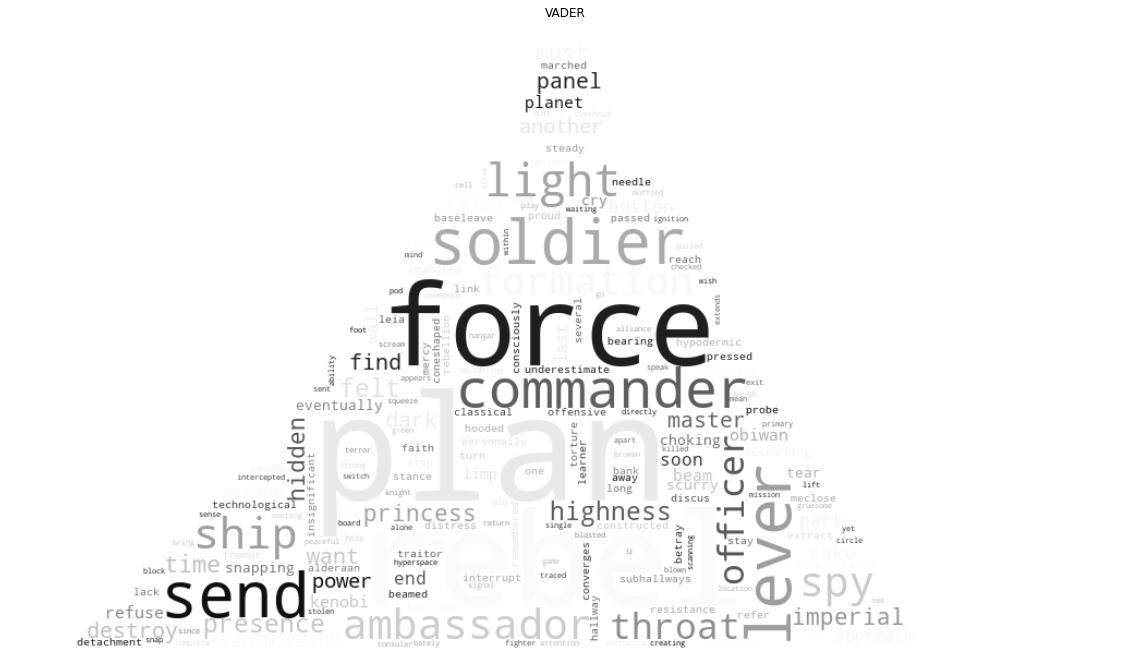

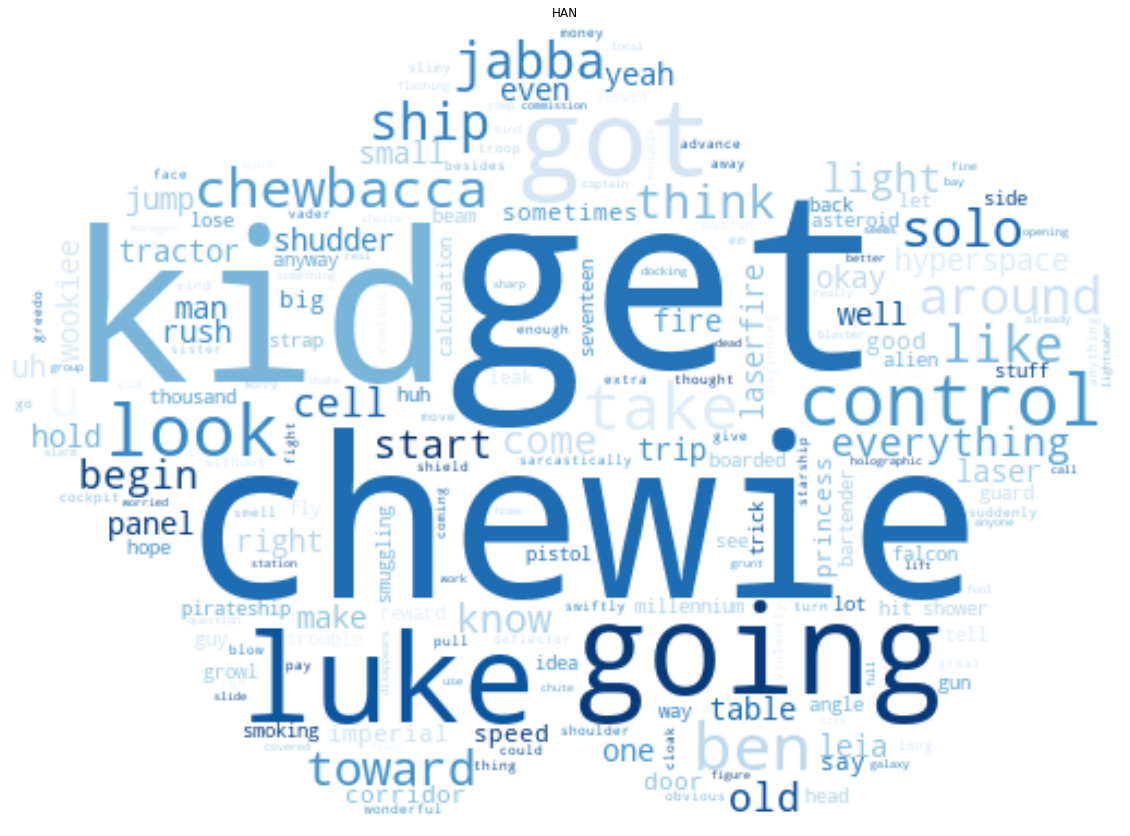

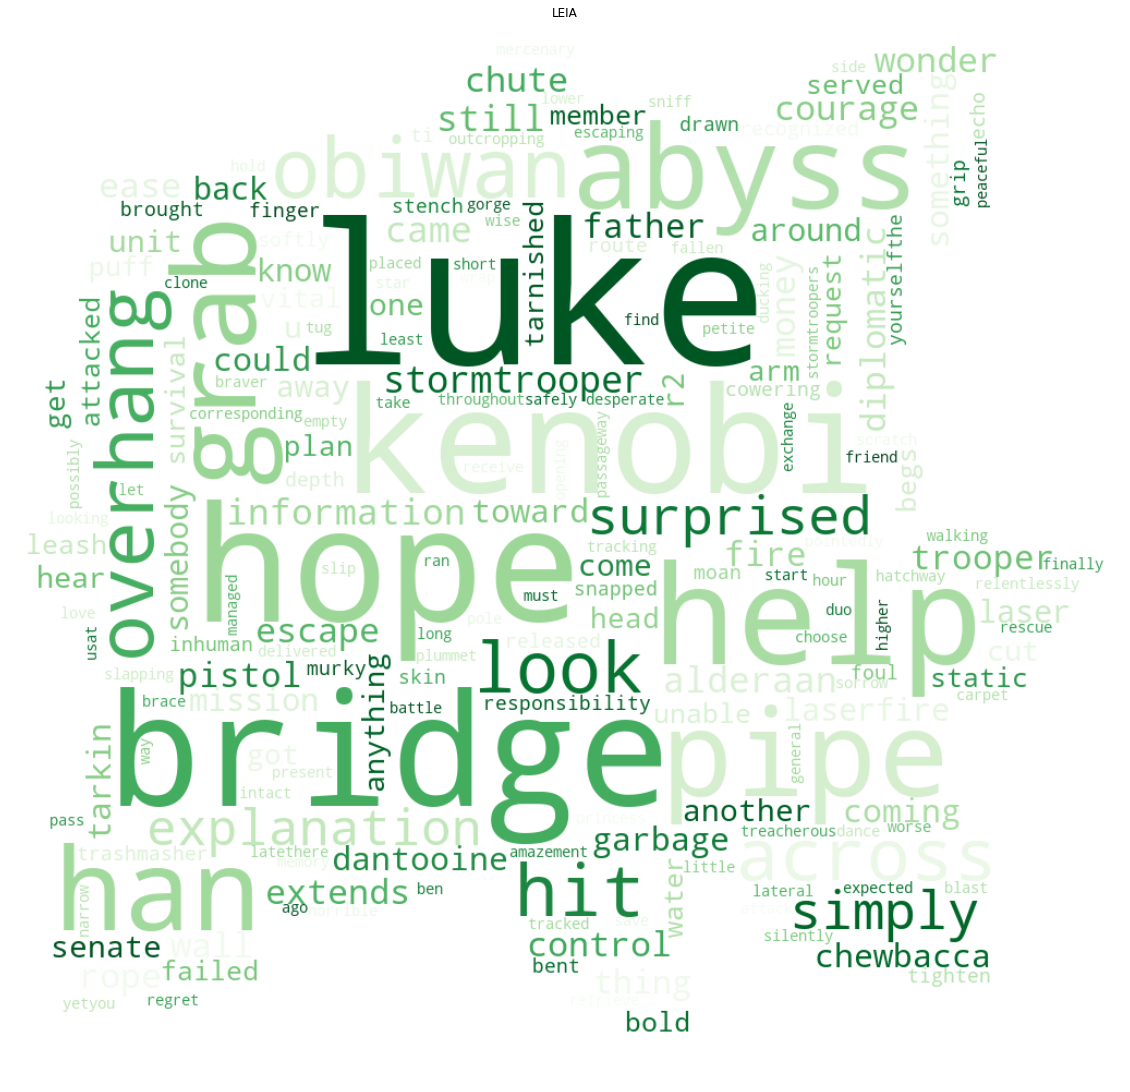

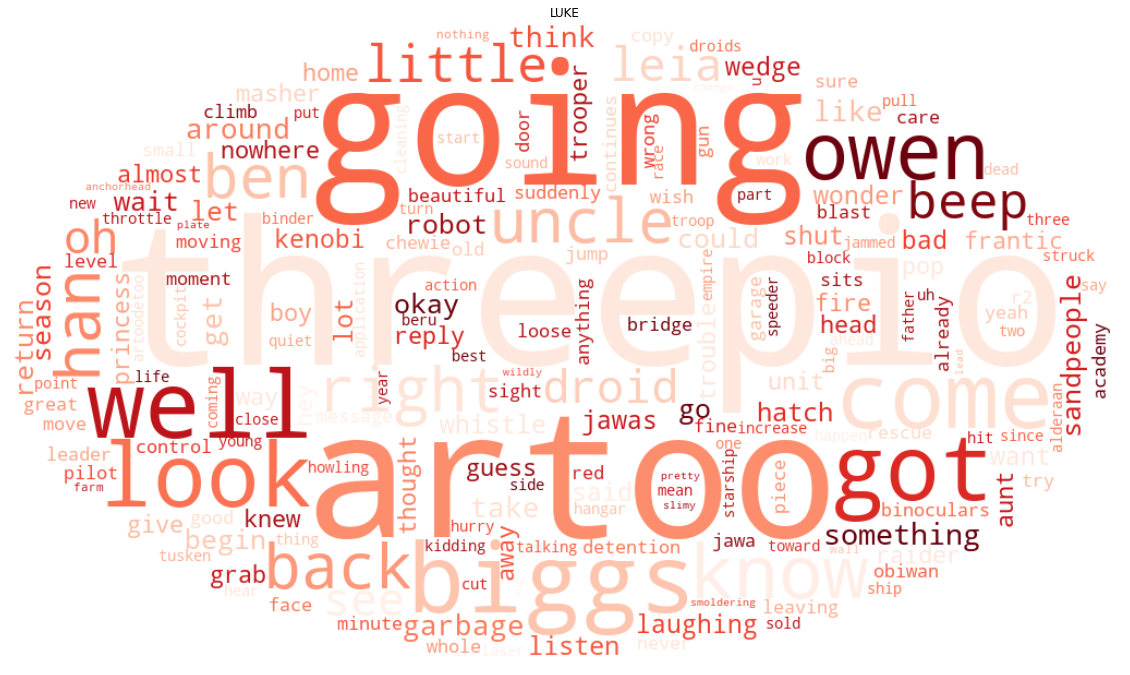

In [52]:
colors = ['Greys', 'Blues', 'Greens', 'Reds']
list_masks = ['Files/Wordcloud/VADER.jpg', 'Files/Wordcloud/CLOUD2.png',
              'Files/Wordcloud/LEAF.jpg', 'Files/Wordcloud/CIRCLE.png']

for i, char in enumerate(characters):
    plt.figure(figsize=[20, 20])
    masks = np.array(Image.open(list_masks[i]))
    wordcloud_race = WordCloud(colormap= colors[i], background_color='white', mask=masks)
    wordcloud_race.generate_from_frequencies(tc_idf[char])
    #plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud_race, interpolation='bilinear')
    plt.axis("off")
    plt.title(char)
    plt.savefig('./Images/Wordclouds/Episode_IV/'+char+'.png')
    plt.show()